<a href="https://colab.research.google.com/github/agapiko/Early_Detection_Of_DIABETIC_RETINOPATHY/blob/main/Densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import json
import cv2
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from keras import layers, Sequential
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.applications import DenseNet121
import math
import time

In [ ]:
df = pd.read_csv('/content/drive/My Drive/labels.csv')

def resize_image(image_path, size=224):
    """Function to open an image, resize it, and return as a numpy array"""
    im = Image.open(image_path)
    im = im.resize((size, size))
    return np.array(im)

def load_image(image_id):
    """Load and resize image from Google Drive"""
    image_path = f'/content/drive/My Drive/train_images_ben_preprocessed_sigmaX10/{image_id}.png'
    return resize_image(image_path)

In [ ]:
# Initial 70-30 split for train and temp (validation + test)
x_train, x_temp, y_train, y_temp = train_test_split(
    df['id_code'], df['diagnosis'], test_size=0.30, stratify=df['diagnosis'], random_state=100
)

# Further split temp into 50-50 for validation and test
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=100
)

print(f"Train size: {len(x_train)}, Validation size: {len(x_val)}, Test size: {len(x_test)}")

Train size: 2563, Validation size: 549, Test size: 550


In [ ]:
x_train_images = np.empty((len(x_train), 224, 224, 3), dtype=np.uint8)
x_val_images = np.empty((len(x_val), 224, 224, 3), dtype=np.uint8)
x_test_images = np.empty((len(x_test), 224, 224, 3), dtype=np.uint8)

In [ ]:
!cp -r /content/drive/MyDrive/train_images_ben_preprocessed_sigmaX10 /content/train_images_local


In [ ]:
from concurrent.futures import ThreadPoolExecutor
# Use ThreadPoolExecutor for parallel image loading and resizing
with ThreadPoolExecutor() as executor:
    train_results = list(executor.map(load_image, x_train))
    val_results = list(executor.map(load_image, x_val))
    test_results = list(executor.map(load_image, x_test))

for i, img in enumerate(train_results):
    x_train_images[i, :, :, :] = img

for i, img in enumerate(val_results):
    x_val_images[i, :, :, :] = img

for i, img in enumerate(test_results):
    x_test_images[i, :, :, :] = img

# Convert labels to one-hot encoding
y_train = pd.get_dummies(y_train).values
y_val = pd.get_dummies(y_val).values
y_test = pd.get_dummies(y_test).values

In [ ]:
# Multilabel Conversion
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_val_multi = np.empty(y_val.shape, dtype=y_val.dtype)
y_test_multi = np.empty(y_test.shape, dtype=y_test.dtype)

y_train_multi[:, 4] = y_train[:, 4]
y_val_multi[:, 4] = y_val[:, 4]
y_test_multi[:, 4] = y_test[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])
    y_val_multi[:, i] = np.logical_or(y_val[:, i], y_val_multi[:, i+1])
    y_test_multi[:, i] = np.logical_or(y_test[:, i], y_test_multi[:, i+1])

print(f"x_train_images shape: {x_train_images.shape}")
print(f"x_val_images shape: {x_val_images.shape}")
print(f"x_test_images shape: {x_test_images.shape}")
print(f"y_train_multi shape: {y_train_multi.shape}")
print(f"y_val_multi shape: {y_val_multi.shape}")
print(f"y_test_multi shape: {y_test_multi.shape}")

x_train_images shape: (2563, 224, 224, 3)
x_val_images shape: (549, 224, 224, 3)
x_test_images shape: (550, 224, 224, 3)
y_train_multi shape: (2563, 5)
y_val_multi shape: (549, 5)
y_test_multi shape: (550, 5)


In [ ]:
y_train

array([[False, False,  True, False, False],
       [False, False,  True, False, False],
       [ True, False, False, False, False],
       ...,
       [False, False,  True, False, False],
       [ True, False, False, False, False],
       [False,  True, False, False, False]])

In [ ]:
y_train_multi

array([[ True,  True,  True, False, False],
       [ True,  True,  True, False, False],
       [ True, False, False, False, False],
       ...,
       [ True,  True,  True, False, False],
       [ True, False, False, False, False],
       [ True,  True, False, False, False]])

In [ ]:
print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1263  259  699  135  207]
Multilabel version: [2563 1300 1041  342  207]


In [ ]:
from tensorflow.keras import backend as K

def exact_match_accuracy(y_true, y_pred):
    y_true = K.cast(y_true, dtype='int32')
    # Threshold predictions to binary values (0 or 1)
    y_pred = K.cast(K.greater(y_pred, 0.5), dtype='int32')
    match = K.all(K.equal(y_true, y_pred), axis=-1)
    return K.mean(K.cast(match, dtype='float32'))

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam

def model_build():
    input_layer = Input(shape=(224, 224, 3))

    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_tensor=input_layer
    )

    # Add custom layers on top of DenseNet121
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(5, activation='sigmoid')(x)  # 5 classes with sigmoid activation

    # Create the final model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.00005),  # Learning rate
    metrics=[exact_match_accuracy]  # Use your custom metric here
    )

    return model

model = model_build()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,042,629 (26.87 MB)

 Trainable params: 6,958,981 (26.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
class Metrics(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data

        # Transform y_val boolean arrays into integer class labels
        y_val_transformed = y_val.sum(axis=1) - 1

        # Predict and apply the same transformation to predictions
        y_pred = self.model.predict(X_val) > 0.5
        y_pred_transformed = y_pred.astype(int).sum(axis=1) - 1

        # Calculate Kappa score
        _val_kappa = cohen_kappa_score(
            y_val_transformed,
            y_pred_transformed,
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        # Log the Kappa score so it's available for plotting later
        logs['val_qwk'] = _val_kappa

        print(f"val_kappa: {_val_kappa:.4f}")

        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('/content/drive/MyDrive/Densenet121_best_awk.h5')

        return

In [ ]:
import tensorflow as tf

def augment_image(image, label):
    # Random flip left-right and up-down
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    rotations = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=rotations)
    return image, label

def create_dataset(x_train, y_train, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train))
    dataset = dataset.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE = 32

train_dataset = create_dataset(x_train_images, y_train_multi, BATCH_SIZE)

def create_validation_dataset(x_val, y_val, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

val_dataset = create_validation_dataset(x_val_images, y_val_multi, BATCH_SIZE)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=4, factor=0.1, min_lr=1e-7, mode='auto',
                              verbose=1)

In [ ]:
kappa_metrics = Metrics(validation_data=(x_val_images, y_val_multi))

# Start time
start_time = time.time()

# Train the model
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[kappa_metrics, early_stop, reduce_lr]
)

# End time
end_time = time.time()

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 415ms/step


val_kappa: 0.5258
Validation Kappa has improved. Saving model.
81/81 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - exact_match_accuracy: 0.2674 - loss: 0.5649 - val_exact_match_accuracy: 0.4622 - val_loss: 0.3630 - val_qwk: 0.5258 - learning_rate: 5.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


val_kappa: 0.8600
Validation Kappa has improved. Saving model.
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - exact_match_accuracy: 0.6578 - loss: 0.2583 - val_exact_match_accuracy: 0.7875 - val_loss: 0.2059 - val_qwk: 0.8600 - learning_rate: 5.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


val_kappa: 0.8883
Validation Kappa has improved. Saving model.
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - exact_match_accuracy: 0.7390 - loss: 0.1802 - val_exact_match_accuracy: 0.7997 - val_loss: 0.1513 - val_qwk: 0.8883 - learning_rate: 5.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
val_kappa: 0.8689
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - exact_match_accuracy: 0.7893 - loss: 0.1496 - val_exact_match_accuracy: 0.7955 - val_loss: 0.1345 - val_qwk: 0.8689 - learning_rate: 5.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


val_kappa: 0.8962
Validation Kappa has improved. Saving model.
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - exact_match_accuracy: 0.7742 - loss: 0.1469 - val_exact_match_accuracy: 0.8031 - val_loss: 0.1299 - val_qwk: 0.8962 - learning_rate: 5.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
val_kappa: 0.8760
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - exact_match_accuracy: 0.8068 - loss: 0.1222 - val_exact_match_accuracy: 0.7990 - val_loss: 0.1279 - val_qwk: 0.8760 - learning_rate: 5.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
val_kappa: 0.8914
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - exact_match_accuracy: 0.8181 - loss: 0.1170 - val_exact_match_accuracy: 0.8135 - val_loss: 0.1219 - val_qwk: 0.8914 - learning_rate: 5.0000e-05
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
val_kappa: 0.8893
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - exact_match_accuracy: 0.8037 - loss: 0.1139 - val_exact_match_accuracy: 0.8083 - val_loss: 0.1279 - val_qwk: 0.8893 - learning_rat

val_kappa: 0.8972
Validation Kappa has improved. Saving model.
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - exact_match_accuracy: 0.8431 - loss: 0.0951 - val_exact_match_accuracy: 0.8111 - val_loss: 0.1274 - val_qwk: 0.8972 - learning_rate: 5.0000e-05
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
val_kappa: 0.8837
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - exact_match_accuracy: 0.8666 - loss: 0.0854 - val_exact_match_accuracy: 0.8181 - val_loss: 0.1280 - val_qwk: 0.8837 - learning_rate: 5.0000e-05
Epoch 13/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
val_kappa: 0.8942
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - exact_match_accuracy: 0.8413 - loss: 0.0906 - val_exact_match_accuracy: 0.8066 - val_loss: 0.1281 - val_qwk: 0.8942 - learning_rate: 5.0000e-05
Epoch 14/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
val_kappa: 0.8801

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - exact_match_accuracy: 0.8774 - loss: 0.0768 - va

Text(0.5, 1.0, 'Training and Validation Accuracy')

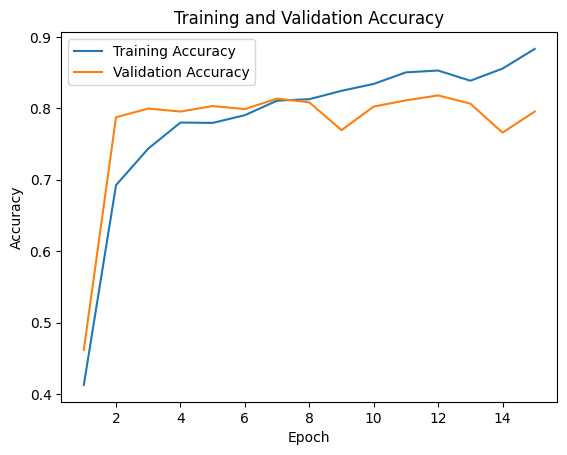

In [ ]:
n_epochs = len(history.history['loss'])
epochs_range = range(1, n_epochs + 1)

# Plot Accuracy
plt.plot(epochs_range, history.history['exact_match_accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_exact_match_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

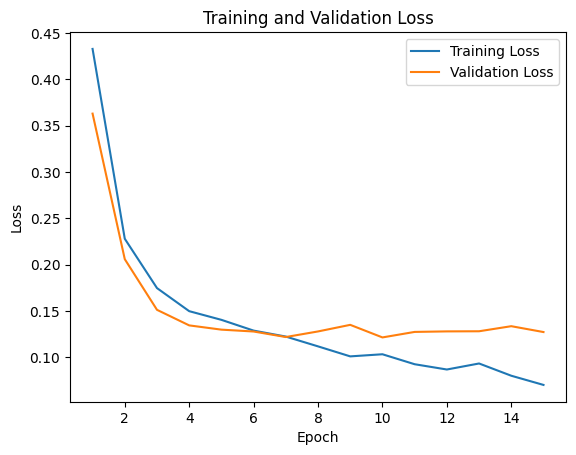

In [ ]:
# Plot Loss
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Validation QWK Score Per Epoch')

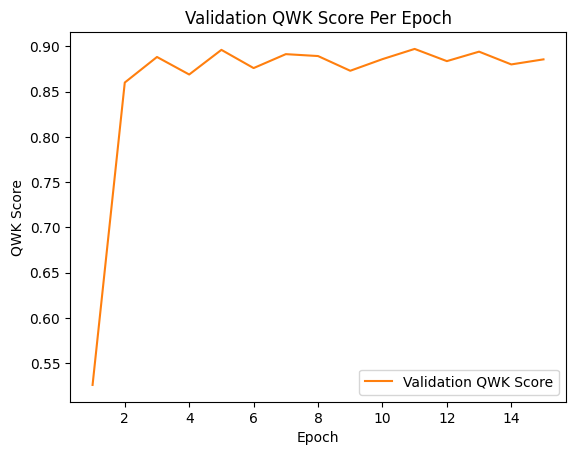

In [ ]:
# Plot QWK (Quadratic Weighted Kappa) Score
plt.plot(epochs_range, history.history['val_qwk'], label='Validation QWK Score', color='#FF7F0E')  # Use the same color as validation loss (orange)
plt.xlabel('Epoch')
plt.ylabel('QWK Score')
plt.legend()
plt.title('Validation QWK Score Per Epoch')

In [ ]:
y_val_pred = model.predict(x_val_images)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [ ]:
print(y_val_pred)

[[9.93818343e-01 6.83441106e-03 6.95407682e-04 2.23937910e-03
  1.55327213e-03]
 [9.94675040e-01 9.63618338e-01 4.63270061e-02 1.44046051e-02
  1.81915723e-02]
 [9.98399436e-01 1.60021614e-03 2.44842726e-04 2.31724844e-04
  5.89019852e-04]
 ...
 [9.97183621e-01 1.02437229e-03 8.37836880e-04 4.65797400e-03
  8.01551156e-03]
 [9.95939195e-01 9.99423921e-01 8.55720639e-01 2.44099516e-02
  3.12380530e-02]
 [9.97365415e-01 9.85698879e-01 1.18990235e-01 1.15595711e-02
  4.89099091e-03]]


In [ ]:
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

def cumulative_to_class(cumulative_labels):
    # For each row, find the last occurrence of `1`
    class_labels = []
    for row in cumulative_labels:
        # Check if there is any `1` in the row
        if 1 in row:
            # Find the last occurrence of 1 and assign that as the class label
            class_labels.append(np.max(np.where(row == 1)[0]))
        else:
            # If no 1 is found, assign class 0
            class_labels.append(0)
    return np.array(class_labels)

In [ ]:
from sklearn.metrics import confusion_matrix

def boolean_to_class(labels):
    return np.argmax(labels, axis=1)

y_val_true_class = boolean_to_class(y_val)
y_val_pred_class = cumulative_to_class(y_val_pred_binary)

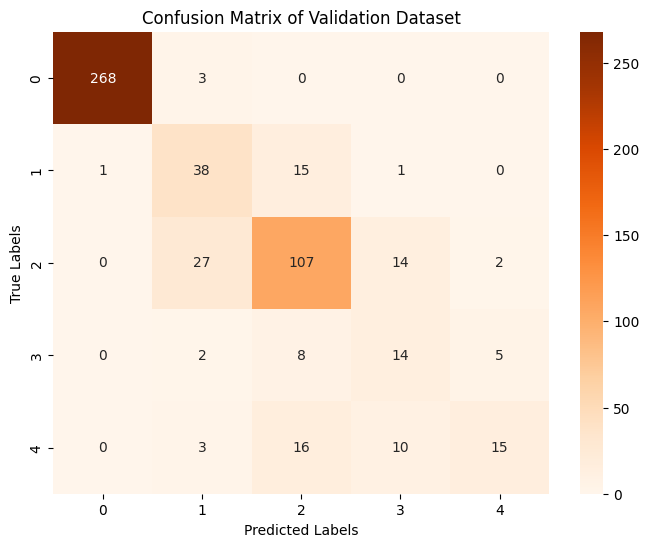

In [ ]:
cm = confusion_matrix(y_val_true_class, y_val_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=True)
plt.title("Confusion Matrix of Validation Dataset")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

## **Evaluation for DenseNet121**

In [ ]:
y_test_pred = model.predict(x_test_images)

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step


In [ ]:
y_test_pred

array([[9.9791080e-01, 2.1298341e-03, 2.9326153e-03, 6.2265131e-03,
        9.1752047e-03],
       [9.9726605e-01, 5.4749520e-04, 5.3397042e-04, 8.0172677e-04,
        2.8734091e-03],
       [9.9796957e-01, 1.1199121e-02, 9.4684743e-04, 2.8775462e-03,
        1.3413485e-03],
       ...,
       [9.9774569e-01, 9.9965143e-01, 9.9134964e-01, 5.6894088e-01,
        5.3952944e-01],
       [9.9880862e-01, 7.7630854e-01, 4.8457715e-01, 3.0507686e-02,
        2.3125635e-02],
       [9.9692482e-01, 4.4578249e-03, 2.6259979e-03, 8.2362574e-03,
        1.7185904e-02]], dtype=float32)

In [ ]:
# Convert the predictions to binary using a threshold (0.5)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Convert both the true and predicted cumulative labels to class labels
y_test_pred_class = cumulative_to_class(y_test_pred_binary)

In [ ]:
y_test_true_class = boolean_to_class(y_test)

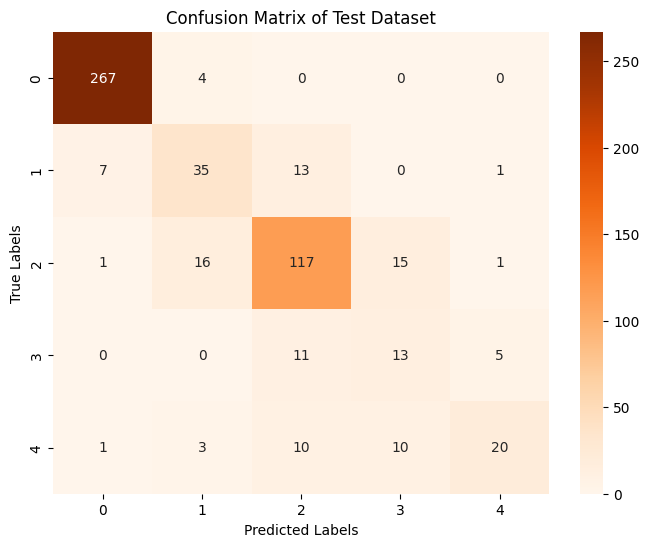

In [ ]:
cm = confusion_matrix(y_test_true_class, y_test_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=True)
plt.title("Confusion Matrix of Test Dataset")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, cohen_kappa_score
import numpy as np

accuracy = accuracy_score(y_test_true_class, y_test_pred_class)
f1 = f1_score(y_test_true_class, y_test_pred_class, average='weighted')
recall = recall_score(y_test_true_class, y_test_pred_class, average='weighted')
y_test_true_onehot = np.eye(len(np.unique(y_test_true_class)))[y_test_true_class]
y_test_pred_onehot = np.eye(len(np.unique(y_test_pred_class)))[y_test_pred_class]
roc_auc = roc_auc_score(y_test_true_onehot, y_test_pred_onehot, average='weighted', multi_class='ovr')
kappa_test_overall = cohen_kappa_score(y_test_true_class, y_test_pred_class, weights='quadratic')
specificity = recall_score(y_test_true_class, y_test_pred_class, pos_label=None, average='weighted', zero_division=1)

# Calculate and print the time taken
training_time = end_time - start_time

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Specifictiy Score: {specificity:.4f}")
print(f"Overall Quadratic Weighted Kappa Score: {kappa_test_overall:.4f}")
print(f"Total training time: {training_time:.2f} seconds")

Accuracy: 0.8218
F1 Score: 0.8211
Recall (Sensitivity): 0.8218
ROC AUC Score: 0.8872
Specifictiy Score: 0.8218
Overall Quadratic Weighted Kappa Score: 0.8964
Total training time: 307.07 seconds
